# Esercitazione 12
### Laboratorio di Simulazione Numerica

Questo jupyter notebook contiene i l'analisi e i risultati relativi all'esercitazione 12 del corso di LSN. La struttura del notebook è la seguente:
- 12.0 caricamento dei pacchetti utili;
- 12.1 svolgimento dell'esercizio 12.1, in cui ho messo a confronto alcune _Deep Neural Networks_ (DNN) compilate utilizzando ottimizzatori diversi;
- 12.2 costruzione di una _Convolutional Neural Network_ (CNN);
- 12.3 utilizzo della CNN creata per riconoscere immagini scritte manualmente; 

---

Le immagini utilizzate per testare la rete e i pesi della CNN nella sua ultima versione sono salvati nella cartella `./Risultati`. 

---

Sconsiglio di ricompilare il jupyter notebook perché alcuni passaggi potrebbero richiedere qualche minuto di tempo.

## 12.0 - Caricamento dei pacchetti utili e preparazione del notebook

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm     #barre di caricamento nei cicli for

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras import datasets, layers, models

from keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop
from keras.datasets import mnist


sns.set_theme(font_scale=1.7, style='whitegrid')

In [5]:
seed=0

np.random.seed(seed) 
tf.random.set_seed(seed)

### Preprocessing dei dati e preparazione dei parametri
Nelle celle seguenti vengono caricati i dati raccolti da MNIST nelle strutture `X_train, X_test, Y_train, Y_test`. Questi, che saranno i dati di input forniti alle reti neurali, verranno modificati nelle dimensioni a seconda delle esigenze delle varie architetture scelte. Nel caso della DNN utilizzata poco più avanti, i dati di input vengono forniti nella forma `(N, 28x28)`. Più avanti (quando useremo la CNN), sarà utile convertire i dati di input nel formato `(N, 28, 28, 1)`. 

Abbiamo inoltre definito alcuni parametri utili in seguito: `img_rows, img_cols, num_classes`.

In [6]:
img_rows, img_cols = 28, 28 
num_classes = 10 

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [7]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

## 12.1 - DNN ed ottimizzatori a confronto

In questo primo esercizio vogliamo mettere a confronto i risultati ottenuti allenando la stessa DNN (mantengo fissati tutti i suoi parametri) con ottimizzatori diversi. Ho scelto di mettere a confronto `SGD, Adam, Adadelta, RMSprop`. Per farlo, ho definito una lista contenente i nomi degli ottimizzatori, tramite cui ho compilato in modo diverso le quattro DNNs, nel modo mostrato di seguito. Ho quindi salvato i valori della funzione di costo e dell'accuratezza, epoca per epoca, per tutte e quattro le opzioni. 

Alcuni commenti in merito alle scelte operate nella costruzione delle reti:
1. la funzione di attivazione nel layer finale è una `softmax`; questa scelta è la più ragionevole quando si affrontano problemi di classificazione;
2. come nel punto 1, la scelta della funzione di costo è motivata dal problema che stiamo affrontando. L'entropia incrociata è molto utile per affrontare classificazioni a molte classi (N classi > 2);
3. come metrica è utile considerare l'accuratezza, ossia il numero di immagini classificate correttamente diviso il totale delle immagini classificate.

In [14]:
optimizators = ['SGD', 'Adam', 'Adadelta', 'RMSprop']

train_loss = []
test_loss  = []
train_acc  = []
test_acc   = []

### Funzione per creare la DNN dato un certo ottimizzatore

In [15]:
def spawn_NN(opt):
    NN = Sequential()
    NN.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    NN.add(Dense(100, activation='relu'))
    NN.add(Dropout(0.5))
    NN.add(Dense(num_classes, activation='softmax'))
    NN.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    return NN

### Training delle diverse DNNs

In [16]:
for opt in optimizators:
    print('Running 10 epochs of training for DNN compiled using '+ str(opt))
    nn = spawn_NN(opt)
    hist = nn.fit(X_train, Y_train, batch_size=32, epochs=10, 
                  verbose=0, validation_data=(X_test, Y_test))
    train_loss.append(hist.history['loss'])
    test_loss.append(hist.history['val_loss'])
    train_acc.append(hist.history['accuracy'])
    test_acc.append(hist.history['val_accuracy'])

print('\n This is the end of all the trainings.')

Running 10 epochs of training for DNN compiled using SGD
Running 10 epochs of training for DNN compiled using Adam
Running 10 epochs of training for DNN compiled using Adadelta
Running 10 epochs of training for DNN compiled using RMSprop

 This is the end of all the trainings.


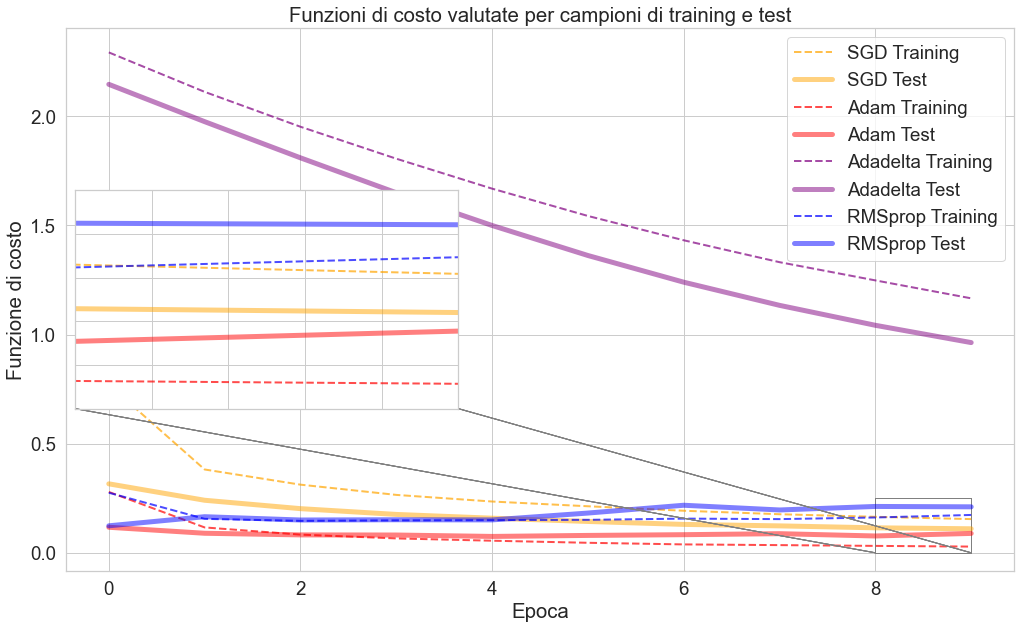

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
colors = ['orange', 'red', 'purple', 'blue']

fig, ax = plt.subplots(figsize=[17, 10])
plt.title('Funzioni di costo valutate per campioni di training e test')
plt.xlabel('Epoca')
plt.ylabel('Funzione di costo')

x1, x2, y1, y2 = 8, 9, 0, 0.25
axins = zoomed_inset_axes(ax, zoom=4, loc=6)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

for i in range(len(optimizators)):
    ax.plot(train_loss[i], color=colors[i], alpha=0.7,
             linewidth=2, linestyle='--', label=str(optimizators[i])+' Training')
    axins.plot(train_loss[i], color=colors[i], alpha=0.7,
             linewidth=2, linestyle='--', label=str(optimizators[i])+' Training')
    ax.plot(test_loss[i], color=colors[i], alpha=0.5,
             linewidth=5, linestyle='-', label=str(optimizators[i])+' Test')
    axins.plot(test_loss[i], color=colors[i], alpha=0.5,
             linewidth=5, linestyle='-', label=str(optimizators[i])+' Test')
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

ax.legend()
plt.show()


__Figura 1:__ andamento del valore della funzione di costo valutata sui set di training (linee continue) e di test (linee tratteggiate). L'ottimizzatore che garantisce la peggior performance è `Adadelta`: è l'unico che non arriva a raggiungere l'80% di accuratezza nella classificazione degli elementi appartenenti al set di test. L'ottimizzatore che fornisce la prestazione migliore a parità di insiemi di test e training e di scelta relativa alla funzione di costo è `Adam`. Come ottimizzatore, Adam è pensato per mantenere un certo grado di inerzia (_momentum based gradiend descent_) nella scelta della direzione e della dimensione del nuovo step da compiere nello spazio dei parametri. Questo lo rende un ottimizzatore particolarmente efficace e flessibile nell'affrontare spazi dei parametri con molte dimensioni.

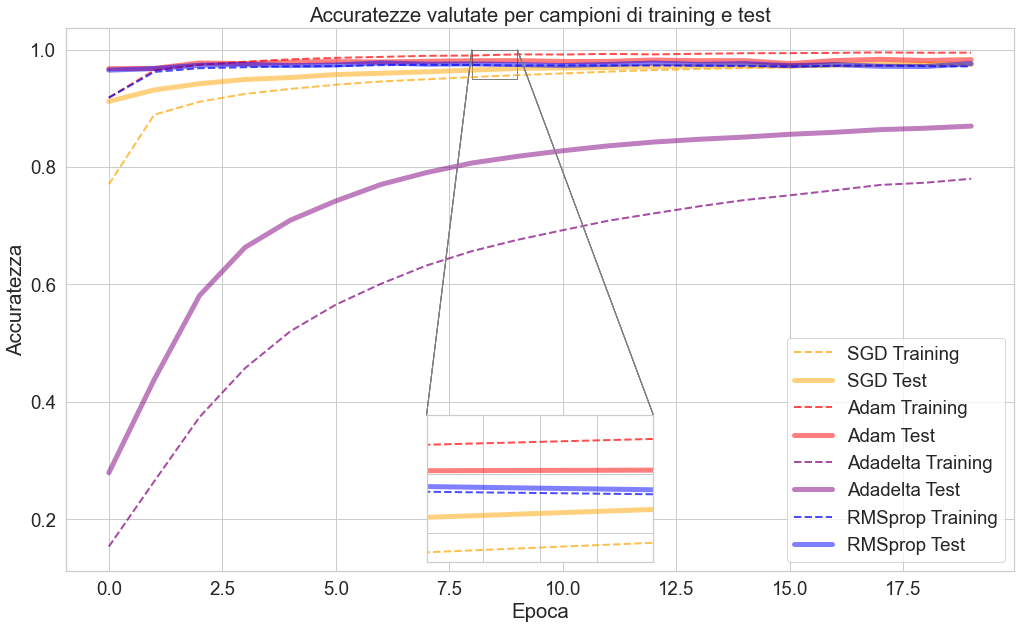

In [13]:
fig, ax = plt.subplots(figsize=[17, 10])
plt.title('Accuratezze valutate per campioni di training e test')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')

x1, x2, y1, y2 = 8, 9, 0.95, 1
axins = zoomed_inset_axes(ax, zoom=5, loc=8)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

for i in range(len(optimizators)):
    ax.plot(train_acc[i], color=colors[i], alpha=0.7,
             linewidth=2, linestyle='--', label=str(optimizators[i])+' Training')
    axins.plot(train_acc[i], color=colors[i], alpha=0.7,
             linewidth=2, linestyle='--', label=str(optimizators[i])+' Training')
    ax.plot(test_acc[i], color=colors[i], alpha=0.5,
             linewidth=5, linestyle='-', label=str(optimizators[i])+' Test')
    axins.plot(test_acc[i], color=colors[i], alpha=0.5,
             linewidth=5, linestyle='-', label=str(optimizators[i])+' Test')
    mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

__Figura 2:__ Come nella Figura 1, anche in questo caso l'ottimizzatore migliore risulta `Adam`.

Abbiamo quindi verificato che le scelte operate nel definire l'architettura di una rete neurale possono influire notevolmente sulla soluzione di un problema.


## 12.2 - Costruzione di una DCNN

L'architettura di una CNN necessita di alcune accortezze nella preparazione dei dati di input. Tali modelli sono infatti pensati per il riconoscimento di oggetti (tipicamente immagini) tramite l'operazione di una sequenza di convoluzioni. 

Nelle righe seguenti abbiamo adattato i dati alla forma `(1, 28, 28, 1)`, così da poterli fornire ad una rete avente come primo layer uno strato operante convoluzione in due dimensioni.

In [87]:
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [88]:
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


### Architettura della mia rete convoluzionale

Ho deciso di costruire la rete secondo il modello sequenziale visto a lezione. Per quanto riguarda gli strati nascosti ho disposto una sequenza di due convoluzioni, ciascuna delle quali seguita da uno strato di _pooling_. Dopo aver applicato uno strato di `dropout` e uno di `BatchNormalization` ho riproposto la parte finale della DNN costruita nell'esercizio 12.1. Come funzione di costo ho scelto nuovamente l'entropia incrociata, come funzione di attivazione nel layer finale la `softmax`. L'ottimizzatore che ho scelto di utilizzare è `Adam`, ossia quello che nell'esercizio precedente ha permesso di ottenere la miglior performance.

In [330]:
def spawn_CNN():
    
    model = Sequential([
    keras.layers.Conv2D(28, kernel_size=(5, 5), input_shape=input_shape, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
    ])
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model

In [191]:
myCNN = spawn_CNN()
myCNN.summary()

myCNN.save_weights('Results/pesi_official.h5')
print('Pesi salvati correttamente')

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 24, 24, 28)        728       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 8, 8, 28)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 16)          4048      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 3, 3, 16)          64        
_________________________________________________________________
flatten_21 (Flatten)         (None, 144)             

### Training della rete

In [192]:
hist = myCNN.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3761 - accuracy: 0.8810 - val_loss: 0.0649 - val_accuracy: 0.9796
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1432 - accuracy: 0.9572 - val_loss: 0.0538 - val_accuracy: 0.9836
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1128 - accuracy: 0.9660 - val_loss: 0.0405 - val_accuracy: 0.9879
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0980 - accuracy: 0.9707 - val_loss: 0.0437 - val_accuracy: 0.9873
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0924 - accuracy: 0.9729 - val_loss: 0.0390 - val_accuracy: 0.9881
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0871 - accuracy: 0.9740 - val_loss: 0.0333 - val_accuracy: 0.9885
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0796 - accuracy: 0.9754 - val_loss: 0.0293 - v

In [196]:
hist_L  = hist.history['loss']
hist_VL = hist.history['val_loss']
hist_A  = hist.history['accuracy']
hist_VA = hist.history['val_accuracy']

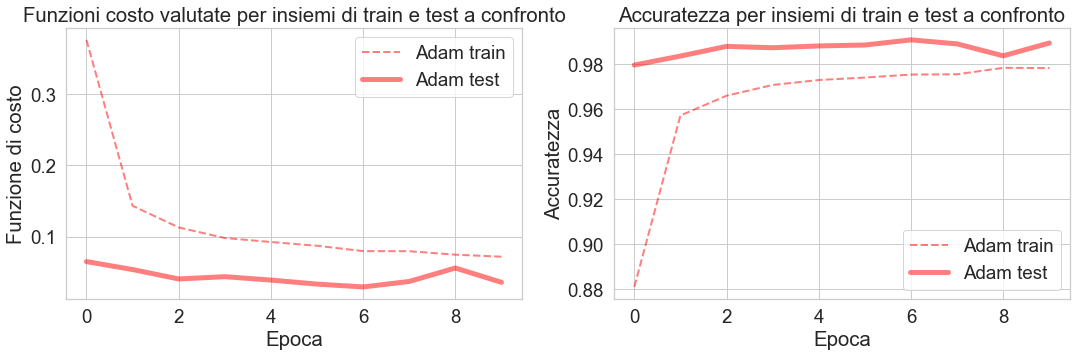

In [335]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title('Funzioni costo valutate per insiemi di train e test a confronto')
plt.plot(hist_L, color='red', alpha=0.5, linewidth=2, linestyle='--', label='Adam train')
plt.plot(hist_VL, color='red', alpha=0.5, linewidth=5, linestyle='-', label='Adam test')
plt.xlabel('Epoca')
plt.ylabel('Funzione di costo')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuratezza per insiemi di train e test a confronto')
plt.plot(hist_A, color='red', alpha=0.5, linewidth=2, linestyle='--', label='Adam train')
plt.plot(hist_VA, color='red', alpha=0.5, linewidth=5, linestyle='-', label='Adam test')
plt.legend()
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()

plt.show()

__Figura 3:__ a sinistra, andamento del valore della funzione di costo registrato in funzione delle epoche e calcolato sul set di training (linea sottile e tratteggiata) e sul set di test (linea spessa e continua). A destra, andamento dei valori di accuratezza registrati rappresentati in modo analogo.

### Valutazione della performance

Per valutare le performance della mia DCNN le sottopongo la classificazione di alcune cifre scritte a mano estratte dal campione di test fornito da MNIST.

In [193]:
score = myCNN.evaluate(X_test, Y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0358 - accuracy: 0.9894
Test loss: 0.03580513596534729
Test accuracy: 0.9894000291824341


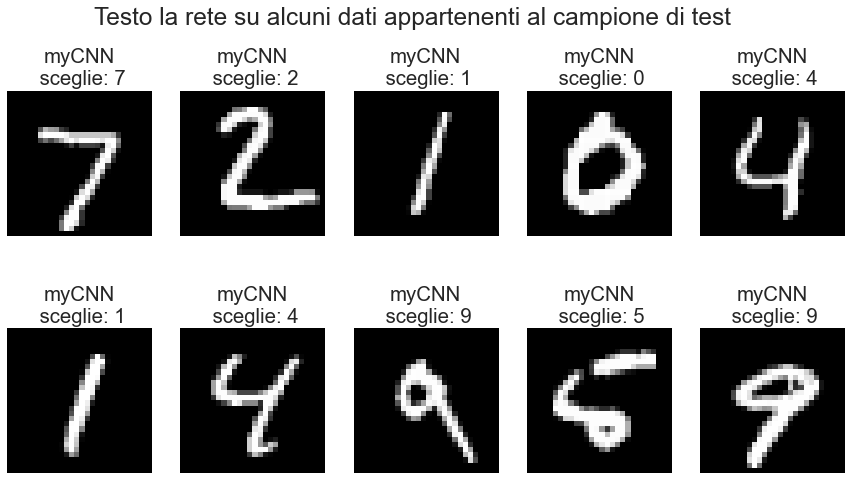

In [195]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = myCNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)


plt.figure(figsize=(15, 8)) 
plt.suptitle('Testo la rete su alcuni dati appartenenti al campione di test')

for i in range(10):    
    ax = plt.subplot(2, 5, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("myCNN\n sceglie: "+str(np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

__Figura 4:__ la DCNN classifica tutte le cifre proposte in modo corretto.

## 12.3 - Testiamo la rete con cifre scritte a mano

Abbiamo infine voluto mettere alla prova la DCNN facendole classificare alcuni numeri scritti manualmente con l'utilizzo dell'applicazione GIMP. 

Inizialmente ho seguito passo per passo le istruzioni fornite dalla consegna, poi ho voluto sperimentare le funzionalità di ridimensionamento delle immagini fornite dal pacchetto `Image` di PIL. Per questo motivo le immagini contenute nella cartella `./Results` sono presentate in un formato diverso da quello previsto dal problema `(28,28,1)`.

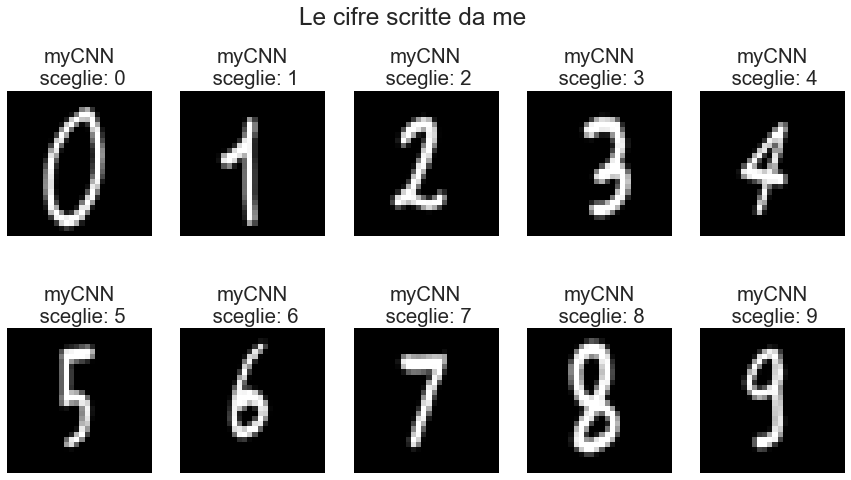

In [199]:
plt.figure(figsize=(15,8))
plt.suptitle('Le cifre scritte da me')

for k in range(10):
    digit_filename = 'Results/hw'+str(k)+'.png'
    img = Image.open(digit_filename).convert('L')
    img = img.resize((28,28))
    
    data = np.asarray(img)
    data = data.reshape(1,28,28,1)
    idx = np.argmax(myCNN.predict(data))
    
    plt.subplot(2,5,k+1)
    plt.imshow(img, cmap='gray')
    plt.title('myCNN\n sceglie: '+str(idx))
    plt.axis('off')
plt.show()

__Figura 5:__ la rete neurale riconosce tutte e dieci le cifre scritte manualmente utilizzando GIMP. 

Per mettere ulteriormente alla prova la rete ho deciso di sottoporle ulteriori cinque immagini, nelle quali ho rappresentato alcune delle dieci cifre sottoposte ad alcune trasformazioni (simmetria, rotazione, ecc). 

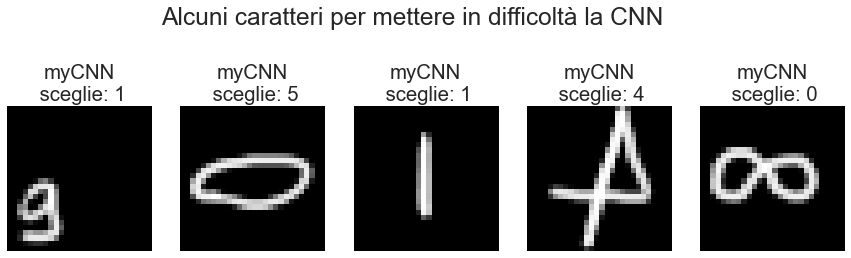

In [202]:
plt.figure(figsize=(15,5))
plt.suptitle('Alcuni caratteri per mettere in difficoltà la CNN')

for k in range(5):
    digit_filename = 'Results/test'+str(k+1)+'.png'
    img = Image.open(digit_filename).convert('L')
    img = img.resize((28,28))
    
    data = np.asarray(img)
    data = data.reshape(1,28,28,1)
    idx = np.argmax(myCNN.predict(data))
    
    plt.subplot(1,5,k+1)
    plt.imshow(img, cmap='gray')
    plt.title('myCNN\n sceglie: '+str(idx))
    plt.axis('off')
plt.show()

__Figura 6:__ Come si può vedere dalle immagini la DCNN fatica a riconoscere la maggior parte di queste cifre, sebbene riesca a classificare in modo corretto, ad esempio, il numero 4, che ho deciso di proporre applicandoci una "simmetria rispetto all'asse della verticale".